# New

In [1]:
from bbq.decoder import d_osd, bp_osd, belief_propagation, _syn_inv_permute_field
from bbq.utils import det_to_err, err_to_det, find_pivots, rref
import numpy as np
from ldpc import BpDecoder, bposd_decoder
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import matplotlib.pyplot as plt
import json
import datetime
import galois

In [2]:
def simulate(field, h, l, max_iter, num_failures, physical_error):

    results = []

    for p in physical_error:

        failures = 0
        num_trials = 0

        while failures < num_failures:
            # Generate syndrome
            n_qudits = h.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, field)
            syndrome = (h @ error) % field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), field), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, field):
                    x_prior[i, j] = prob / (field - 1)

            # Decode
            # guessed_error, decoder_success, bp_success, posterior = belief_propagation(field, h, syndrome, x_prior, max_iter, debug=True)
            guessed_error, decoder_success, bp_success, posterior = bp_osd(field, h, syndrome, x_prior, max_iter, order=0, debug=True)
            error_difference = (error - guessed_error) % field
            logical_effect = (np.array(l) @ error_difference) % field

            # Check success
            # if np.any(logical_effect != 0) or not decoder_success:
            if np.any(logical_effect != 0):
                failures += 1
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            num_trials += 1

        results.append(num_trials)

        print(f'Finished p={p} with num_trials={num_trials}')
    return results

In [18]:
a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))
bb2 = BivariateBicycle(a, b, 3, 3, 1)
h2 = bb2.hx
l2 = bb2.x_logicals
bb25 = BivariateBicycle(a, b, 5, 5, 1)
h25 = bb25.hx
l25 = bb25.x_logicals
bb27 = BivariateBicycle(a, b, 7, 7, 1)
h27 = bb27.hx
l27 = bb27.x_logicals

a = Polynomial(3, np.array([[1, 0], [-1, 0]]))
b = Polynomial(3, np.array([[1, -1], [0, 0]]))
bb3 = BivariateBicycle(a, b, 3, 3, 1)
h3 = bb3.hx
l3 = bb3.x_logicals
bb35 = BivariateBicycle(a, b, 5, 5, 1)
h35 = bb35.hx
l35 = bb35.x_logicals
bb37 = BivariateBicycle(a, b, 7, 7, 1)
h37 = bb37.hx
l37 = bb37.x_logicals

a = Polynomial(5, np.array([[1, 0], [-1, 0]]))
b = Polynomial(5, np.array([[1, -1], [0, 0]]))
bb5 = BivariateBicycle(a, b, 3, 3, 1)
h5 = bb5.hx
l5 = bb5.x_logicals

max_iter = 1000
num_failures = 3
# physical_error = np.flip(np.logspace(-2.7, -1, 10))
physical_error = np.flip(np.logspace(-1.7, -0.7, 10))

In [4]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

In [ ]:
full_results_35 = np.flip(simulate(3, h35, l35, max_iter, num_failures, physical_error))

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:105: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, :] = sub_convolution[syn_inv_permutation[errs[j, 1], :]]


Found 1 / 3, with num_trials : 2
Found 2 / 3, with num_trials : 3
Found 3 / 3, with num_trials : 4
Finished p=0.19952623149688797 with num_trials=5
Found 1 / 3, with num_trials : 1
Found 2 / 3, with num_trials : 2
Found 3 / 3, with num_trials : 6
Finished p=0.15448591479026755 with num_trials=7
Found 1 / 3, with num_trials : 0
Found 2 / 3, with num_trials : 8
Found 3 / 3, with num_trials : 13
Finished p=0.11961283330787534 with num_trials=14
Found 1 / 3, with num_trials : 1
Found 2 / 3, with num_trials : 11


In [ ]:
full_results_35

In [ ]:
#results = {3 : full_results_3}
results = {3 : full_results_3, 5 : full_results_35}
#results = {3 : full_results_3, 5 : full_results_35, 7 : full_results_37}

x = np.flip(physical_error)
plot_num_failures = {3 : 3, 5 : 3, 7 : 3}
plot_results, plot_error_bars = process_results(results, plot_num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
#plt.loglog(x, plot_results[7], color='royalblue')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
#plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qudit Toric Code under Code Capacity');

In [11]:
full_results_2 = [355, 321, 86, 62, 57, 6, 18, 15, 16, 5]
full_results_3 = [129, 353, 149, 162, 29, 31, 12, 22, 7, 6]
full_results_5 = [487, 167, 136, 247, 77, 65, 14, 23, 5, 10]

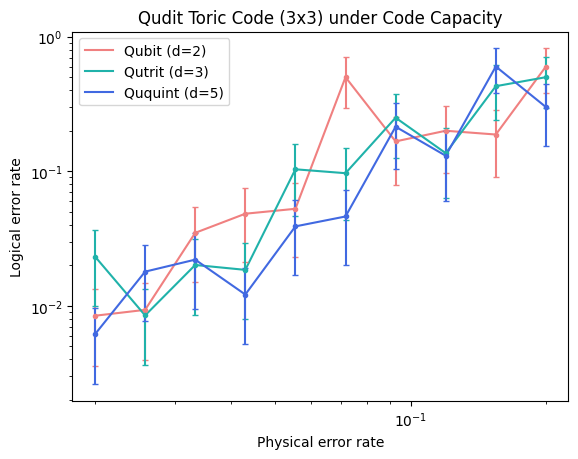

In [ ]:
#results = {2 : full_results_2}
#results = {2 : full_results_2, 3 : full_results_3}
results = {2 : full_results_2, 3 : full_results_3, 5 : full_results_5}

x = physical_error
plot_num_failures = {2 : 3, 3 : 3, 5 : 3}
plot_results, plot_error_bars = process_results(results, plot_num_failures)

plt.loglog(x, plot_results[2], color='lightcoral')
plt.loglog(x, plot_results[3], color='lightseagreen')
plt.loglog(x, plot_results[5], color='royalblue')

plt.errorbar(x, plot_results[2], yerr=plot_error_bars[2], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['Qubit (d=2)', 'Qutrit (d=3)', 'Ququint (d=5)'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qudit Toric Codes (3x3) under Code Capacity');

# Old

In [ ]:
from utils import *
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import galois
from scipy.sparse import coo_matrix, hstack
import json
import datetime

In [13]:
a = np.array([0, 1, 2, 2])
b = [1, 2, 4, 6]

In [15]:
a/b
5/91

0.054945054945054944

## Utils

In [2]:
def construct_sm_circuit(self, x_order : list, z_order : list) -> list:
    """Construct one cycle of the syndrome measurement circuit for the Bivariate Bicycle code.
    
    Parameters
    ----------
    x_order : list
        List of integers or 'Idle' defining the order of the CNOTs for x stabilisers.
    y_order : list
        List of integers or 'Idle' defining the order of the CNOTs for y stabilisers.
    
    Returns
    -------
    circ : list
        List of gates in one cycle of the syndrome circuit: ('CNOT', control_qubit, target_qubit, power), ('Idle', qubit), ('Meas_X', qubit), ('Meas_Z', qubit), ('Prep_X', qubit), ('Prep_Z', qubit).
    """
    if not isinstance(x_order, list):
        raise TypeError("x_order must be a list")
    if not isinstance(z_order, list):
        raise TypeError("y_order must be a list")
    for gate in x_order:
        if not (isinstance(gate, int) or gate == 'Idle'):
            raise TypeError("x_order must be an array of integers or 'Idle'")
    for gate in z_order:
        if not (isinstance(gate, int) or gate == 'Idle'):
            raise TypeError("z_order must be an array of integers or 'Idle'")
    if not x_order[0] == 'Idle':
        raise ValueError("First x_order round must be 'Idle'")
    if not z_order[-1] == 'Idle':
        raise ValueError("Last y_order round must be 'Idle'")
    for i in range(len(np.nonzero(self.hx[0])[0])):
        if i not in x_order:
            raise ValueError("x_order must contain all target qubits")
    for i in range(len(np.nonzero(self.hz[0])[0])):
        if i not in z_order:
            raise ValueError("y_order must contain all target qubits")
    if len(x_order) > len(z_order):
        z_order += ['Idle'] * (len(x_order) - len(z_order))
    elif len(z_order) > len(x_order):
        x_order += ['Idle'] * (len(z_order) - len(x_order))

    hx, hz = self.hx, self.hz
    a, b = self.a, self.b
    l, m, q = self.l, self.m, self.q
    field = self.field
    A, B = self.A, self.B
    qubits_dict, data_qubits, x_checks, z_checks = self.qubits_dict, self.data_qubits, self.x_checks, self.z_checks
    edges = self.edges

    # Construct the circuit
    circ = []
    U = np.identity(4*l*m, dtype=int)  # to verify CNOT order

    # For each time step, add the corresponding gate:
    # ('CNOT', control_qubit, target_qubit, power), ('Idle', qubit), ('Meas_X', qubit), ('Meas_Y', qubit), ('Prep_X', qubit)

    # Round 0: Prepare X checks, CNOT/Idle Z checks
    t = 0
    cnoted_data_qubits = []
    for qubit in x_checks:
        circ.append(('Prep_X', qubit))
    if z_order[t] == 'Idle':
        for qubit in z_checks:
            circ.append(('Idle', qubit))
    else:
        for target in z_checks:
            direction = z_order[t]
            control, power = edges[(target, direction)]
            U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
            cnoted_data_qubits.append(control)
            circ.append(('CNOT', control, target, power))
    for qubit in data_qubits:
        if not (qubit in cnoted_data_qubits):
            circ.append(('Idle', qubit))

    # Round [1, (max-1)]: CNOT/Idle X checks, CNOT/Idle Z checks
    for t in range(1, len(x_order)-1):
        cnoted_data_qubits = []
        if x_order[t] == 'Idle':
            for qubit in x_checks:
                circ.append(('Idle', qubit))
        else:
            for control in x_checks:
                direction = x_order[t]
                target, power = edges[(control, direction)]
                U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
                cnoted_data_qubits.append(target)
                circ.append(('CNOT', control, target, power))
        if z_order[t] == 'Idle':
            for qubit in z_checks:
                circ.append(('Idle', qubit))
        else:
            for target in z_checks:
                direction = z_order[t]
                control, power = edges[(target, direction)]
                U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
                cnoted_data_qubits.append(control)
                circ.append(('CNOT', control, target, power))
        for qubit in data_qubits:
            if not (qubit in cnoted_data_qubits):
                circ.append(('Idle', qubit))

    # Round max: CNOT/Idle X checks, Measure Z checks
    t = -1
    cnoted_data_qubits = []
    for qubit in z_checks:
        circ.append(('Meas_Z', qubit))
    if x_order[t] == 'Idle':
        for qubit in x_checks:
            circ.append(('Idle', qubit))
    else:
        for control in x_checks:
            direction = x_order[t]
            target, power = edges[(control, direction)]
            U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
            circ.append(('CNOT', control, target, power))
            cnoted_data_qubits.append(target)
    for qubit in data_qubits:
        if not (qubit in cnoted_data_qubits):
            circ.append(('Idle', qubit))
    
    # Round final: Measure X checks, Prepare Z checks
    for qubit in data_qubits:
        circ.append(('Idle', qubit))
    for qubit in x_checks:
        circ.append(('Meas_X', qubit))
    for qubit in z_checks:
        circ.append(('Prep_Z', qubit))

    # Test measurement circuit against max depth circuit
    V = np.identity(4*l*m, dtype=int)
    for t in range(len(x_order)):
        if not x_order[t] == 'Idle':
            for control in x_checks:
                direction = x_order[t]
                target, power = edges[(control, direction)]
                V[qubits_dict[target], :] = (V[qubits_dict[target], :] + power * V[qubits_dict[control], :]) % field
    for t in range(len(z_order)):
        if not z_order[t] == 'Idle':
            for target in z_checks:
                direction = z_order[t]
                control, power = edges[(target, direction)]
                V[qubits_dict[target], :] = (V[qubits_dict[target], :] + power * V[qubits_dict[control], :]) % field
    if not np.array_equal(U, V):
        raise ValueError("Syndrome circuit does not match max depth syndrome circuit, check stabiliser orders")

    return circ

In [3]:
def construct_decoding_matrix(self, circ : list, error_rates : dict, num_cycles : int = 1) -> np.ndarray:
    """Construct decoding matrix for a given syndrome circuit.
    
    Parameters
    ----------
    circ : list
        List of gates in one cycle of the syndrome circuit: ('CNOT', control_qubit, target_qubit, power), ('Idle', qubit), ('Meas_X', qubit), ('Meas_Z', qubit), ('Prep_X', qubit), ('Prep_Z', qubit).
    error_rate : dict
        Dictionary of error rates for keys [Meas, Prep, Idle, CNOT].
    num_cycles : int
        Number of cycles to repeat the syndrome circuit. Default is 1.
    
    Returns
    -------
    hx_eff : coo_matrix
        Decoding matrix for X stabilisers.    
    short_hx_eff : coo_matrix
        Decoding matrix for X stabilisers without columns for logicals.    
    hz_eff : coo_matrix
        Decoding matrix for Z stabilisers.    
    short_hz_eff : coo_matrix
        Decoding matrix for Z stabilisers without columns for logicals.
    channel_prob_x : list
        List of probabilities for each X syndrome, i.e. each column in hx_eff.    
    channel_prob_z : list
        List of probabilities for each Z syndrome, i.e. each column in hz_eff.
    """
    if not (isinstance(error_rates, dict)):
        raise TypeError("error_rates must be a dictionary")
    for key in error_rates.keys():
        if (key not in ['Meas', 'Prep', 'Idle', 'CNOT']) or (len(error_rates) != 4):
            raise ValueError("error_rates must have keys ['Meas', 'Prep', 'Idle', 'CNOT']")
        if not (isinstance(error_rates[key], float) and 0 <= error_rates[key] <= 1):
            raise ValueError("error_rates must have values between 0 and 1")
    if not (isinstance(num_cycles, int) and num_cycles > 0):
        raise TypeError("num_cycles must be a positive integer")

    l, m = self.l, self.m
    field = self.field
    qubits_dict, data_qubits = self.qubits_dict, self.data_qubits
    x_logicals, z_logicals = self.x_logicals, self.z_logicals
    x_checks, z_checks = self.x_checks, self.z_checks

    # Construct repeated circuit
    repeated_circ = circ * num_cycles

    # Single error circuits
    z_prob, z_circuit = [], []
    x_prob, x_circuit = [], []
    head = []
    tail = repeated_circ.copy()
    for gate in repeated_circ:
        # assert gate[0] in ['CNOT', 'Idle', 'Meas_X', 'Meas_Z', 'Prep_X', 'Prep_Z']
        if gate[0] == 'Meas_X':
            # Meas_X error only affects Z detectors
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['Meas'])
        if gate[0] == 'Meas_Z':
            # Meas_Z error only affects X detectors
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['Meas'])
        head.append(gate)
        tail.pop(0)
        # assert repeated_circ == head + tail
        if gate[0] == 'Prep_X':
            # Prep_X error only affects Z detectors
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['Prep'])
        if gate[0] == 'Prep_Z':
            # Prep_Z error only affects X detectors
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['Prep'])
        if gate[0] == 'Idle':
            # Idle error on Z detectors
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['Idle']*2/3)  # 3 possible Idle errors are X, Y, Z so Z is 2/3 (Y and Z)
            # Idle error on X detectors
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['Idle']*2/3)
        if gate[0] == 'CNOT':
            # Z error on control
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['CNOT']*4/15)  # possible CNOT errors are IX, IY, ..., ZZ so Z is 4/15 (IZ, IY, XZ and XY)
            # Z error on target
            z_circuit.append(head + [('Z', gate[2])] + tail)
            z_prob.append(error_rates['CNOT']*4/15)
            # Z error on both
            z_circuit.append(head + [('ZZ', gate[1], gate[2])] + tail)
            z_prob.append(error_rates['CNOT']*4/15)
            # X error on control
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['CNOT']*4/15)
            # X error on target
            x_circuit.append(head + [('X', gate[2])] + tail)
            x_prob.append(error_rates['CNOT']*4/15)
            # X error on both
            x_circuit.append(head + [('XX', gate[1], gate[2])] + tail)
            x_prob.append(error_rates['CNOT']*4/15)

    # Execute each noisy X circuit and compute syndrome
    # Add two noiseless syndrome cycles to end
    cnt = 0
    Hx_dict = {}
    for x_circ in x_circuit:
        syndrome_history, state, syndrome_map, err_cnt = self._simulate_x_circuit(x_circ + circ + circ)
        assert err_cnt == 1
        assert len(syndrome_history) == l * m * (num_cycles + 2)

        # Compute final state of data qubits and logical effect
        state_data_qubits = [state[qubits_dict[qubit]] for qubit in data_qubits]
        syndrome_final_logical = (np.array(z_logicals) @ state_data_qubits) % field

        # Syndrome sparsification, i.e. only keep syndrome entries that change from previous cycle
        syndrome_history_copy = syndrome_history.copy()
        for check in z_checks:
            pos = syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                syndrome_history[pos[row]] += syndrome_history_copy[pos[row-1]]
        syndrome_history %= field

        # Combine syndrome_history and syndrome_final_logical
        syndrome_history_augmented = np.hstack([syndrome_history, syndrome_final_logical])

        # Hx_dict maps flagged Z stabilisers to corresponding noisy circuit, i.e. Hx_dict[flagged_z_stab] = [noisy_circuit_1, noisy_circuit_2, ...]
        supp = tuple(np.nonzero(syndrome_history_augmented)[0])
        if supp in Hx_dict:
            Hx_dict[supp].append(cnt)
        else:
            Hx_dict[supp] = [cnt]
        cnt += 1

    first_logical_row_x = l * m * (num_cycles + 2)
    num_x_errors = len(Hx_dict)  # Number of distinct X syndrome histories
    k = len(x_logicals) # Number of logical qubits
    hx_eff, short_hx_eff = [], []
    channel_prob_x = []
    for supp in Hx_dict:
        new_col = np.zeros((l * m * (num_cycles + 2) + k, 1), dtype=int)  # With the augmented part for logicals
        new_col_short = np.zeros((l * m * (num_cycles + 2), 1), dtype=int)
        new_col[list(supp), 0] = 1  # 1 indicates which stabiliser is flagged
        new_col_short[:, 0] = new_col[0:first_logical_row_x, 0]
        hx_eff.append(coo_matrix(new_col))
        short_hx_eff.append(coo_matrix(new_col_short))
        channel_prob_x.append(np.sum([x_prob[i] for i in Hx_dict[supp]]))  # Probability of a given x syndrome
    hx_eff = hstack(hx_eff)  # Column = error mechanism, row = flagged stabilisers
    short_hx_eff = hstack(short_hx_eff)  # Shortened hx_eff without columns for logicals

    # Execute each noisy Z circuit and compute syndrome
    # Add two noiseless syndrome cycles to end
    cnt = 0
    Hz_dict = {}
    for z_circ in z_circuit:
        syndrome_history, state, syndrome_map, err_cnt = self._simulate_z_circuit(z_circ + circ + circ)
        assert err_cnt == 1
        assert len(syndrome_history) == l * m * (num_cycles + 2)

        # Compute final state of data qubits and logical effect
        state_data_qubits = [state[qubits_dict[qubit]] for qubit in data_qubits]
        syndrome_final_logical = (np.array(x_logicals) @ state_data_qubits) % field

        # Syndrome sparsification, i.e. only keep syndrome entries that change from previous cycle
        syndrome_history_copy = syndrome_history.copy()
        for check in x_checks:
            pos = syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                syndrome_history[pos[row]] += syndrome_history_copy[pos[row-1]]
        syndrome_history %= field

        # Combine syndrome_history and syndrome_final_logical
        syndrome_history_augmented = np.hstack([syndrome_history, syndrome_final_logical])

        # Hz_dict maps flagged X stabilisers to corresponding noisy circuit, i.e. Hz_dict[flagged_x_stab] = [noisy_circuit_1, noisy_circuit_2, ...]
        supp = tuple(np.nonzero(syndrome_history_augmented)[0])
        if supp in Hz_dict:
            Hz_dict[supp].append(cnt)
        else:
            Hz_dict[supp] = [cnt]
        cnt += 1

    first_logical_row_z = l * m * (num_cycles + 2)
    num_z_errors = len(Hz_dict)  # Number of distinct Z syndrome histories
    hz_eff, short_hz_eff = [], []
    channel_prob_z = []
    for supp in Hz_dict:
        new_col = np.zeros((l * m * (num_cycles + 2) + k, 1), dtype=int)  # With the augmented part for logicals
        new_col_short = np.zeros((l * m * (num_cycles + 2), 1), dtype=int)
        new_col[list(supp), 0] = 1  # 1 indicates which stabiliser is flagged
        new_col_short[:, 0] = new_col[0:first_logical_row_z, 0]
        hz_eff.append(coo_matrix(new_col))
        short_hz_eff.append(coo_matrix(new_col_short))
        channel_prob_z.append(np.sum([z_prob[i] for i in Hz_dict[supp]]))  # Probability of a given z syndrome
    hz_eff = hstack(hz_eff)  # Row = flagged stabilisers, column = noisy circuit
    short_hz_eff = hstack(short_hz_eff)  # Shortened hz_eff without columns for logicals

    return hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, x_circuit, z_circuit

In [2]:
def rref_with_pivots(A, v, x = None):
    """
    Perform Gaussian elimination to find the reduced row echelon form (RREF).
    Also identifies the pivot columns.
    Also reduces a vector to keep a linear system invariant.
    
    Parameters
    ----------
    A : Galois field array
        Galois field matrix to row reduce
        
    Returns
    -------
    A_rref : Galois field array
        Row-reduced form of A
    pivots : list
        Indices of pivot columns
    """
    # Get a copy to avoid modifying the original
    A_rref = A.copy()
    v_rref = v.copy()
    m, n = A_rref.shape
    assert v.shape == (m,)
    # assert (A_rref @ x == v_rref).all()
    
    # Track the pivot positions
    pivot_cols = []
    pivot_rows = []
    
    # Iterate through columns
    for c in range(n):
        # Find pivot in column c
        for r in range(m):
            if A_rref[r, c] != 0 and r not in pivot_rows:
                break
        else:
            continue

        # Record this column as a pivot column
        pivot_cols.append(c)
        pivot_rows.append(r)
        
        # Scale the pivot row to make the pivot element 1
        pivot = A_rref[r, c]
        A_rref[r] = A_rref[r] / pivot
        v_rref[r] = v_rref[r] / pivot
        
        # Eliminate other elements in the pivot column
        for i in range(m):
            if i != r and A_rref[i, c] != 0:
                v_rref[i] = v_rref[i] - A_rref[i,c] * v_rref[r]
                A_rref[i] = A_rref[i] - A_rref[i, c] * A_rref[r]
        
        # If we've exhausted all rows, we're done
        if len(pivot_rows) == m:
            break
    
    # if len(pivot_rows) < A.shape[0]:
    #     print("Matrix is not full rank.")

    return A_rref[sorted(pivot_rows)], v_rref[sorted(pivot_rows)], pivot_cols

In [5]:
def dijkstra_osd_decode(self, syndrome_history, prior, h_eff, debug = False):
    """Decode the syndrome using D+OSD.
    
    Parameters
    ----------
    syndrome_history : nd.array
        The syndrome of the error.
    prior : nd.array
        The probability of each error mechanism.
    h_eff : nd.array
        The effective parity check matrix, where columns = error mechanism and rows = syndrome (flagged stabilisers).

    Returns
    -------
    error : nd.array
        The estimated error.
    """
    if not isinstance(syndrome_history, np.ndarray):
        raise TypeError('syndrome must be a numpy array')
    if not isinstance(prior, np.ndarray):
        raise TypeError('prior must be a np.ndarray')

    field = self.field
    qubits_dict = self.qubits_dict
    data_qubits, x_checks, z_checks = self.data_qubits, self.x_checks, self.z_checks

    m, n = h_eff.shape

    # Mini-Dijkstra
    check_distances = np.ones(m) * n
    error_distances = np.ones(n) * n

    # Set the distance each detector is from an error
    for c in syndrome_history.nonzero()[0]:
        check_distances[c] = 0

    update_made = True
    while update_made:
        update_made = False
        for c in range(m):
            current_distance = check_distances[c]
            for e in np.nonzero(h_eff[c])[0]:
                if current_distance + 1 < error_distances[e]:
                    error_distances[e] = current_distance + 1
                    update_made = True

        for e in range(n):
            current_distance = error_distances[e]
            for c in np.nonzero(h_eff[:,e])[0]:
                if current_distance + 1 < check_distances[c]:
                    check_distances[c] = current_distance + 1
                    update_made = True

    certainties = error_distances

    # Sort errors by how certain we are of their values (most to least)
    col_rank_perm = np.argsort(certainties)
    col_rank_inv_perm = np.empty_like(col_rank_perm)
    col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))

    # Create Galois field elements
    GF = galois.GF(field)

    # Convert H and syndrome to Galois field arrays
    H_gf = GF(h_eff.copy())
    syndrome_gf = GF(syndrome_history.copy())
    
    # Order the columns of h_gf and prior according to the ranking
    H_ordered_gf = H_gf[:, col_rank_perm]
    priors_perm = prior[col_rank_perm]

    # Find the reduced row echelon form (RREF) and identify pivot columns
    H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
    m_ind = H_rref_gf.shape[0]
    non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

    # Select the first rank(h_gf) linearly independent columns as basis set in P, others in B
    P = H_rref_gf[:, pivot_cols]
    assert P.shape == (m_ind, m_ind)
    B = H_rref_gf[:, non_pivot_cols]

    def sln_from(g):
        assert g.shape == (n - m_ind,)
        remainder =  syndrome_rref_gf - B @ g
        fix = np.linalg.solve(P, remainder)
        assert (P @ fix + B @ g == syndrome_rref_gf).all()

        score = 0
        sln = GF.Zeros(n)
        # Find prob of basis set
        for i in range(m_ind):
            p = priors_perm[pivot_cols[i], fix[i]]
            sln[pivot_cols[i]] = fix[i]
            if p > 0:
                score += np.log(p)
            else:
                score -= 1000
        
        for i in range(n - m_ind):
            p = priors_perm[non_pivot_cols[i], g[i]]
            sln[non_pivot_cols[i]] = g[i]
            if p > 0:
                score += np.log(p)
            else:
                score -= 1000

        # Check sln makes correct syndrome
        assert (H_rref_gf @ sln == syndrome_rref_gf).all()
        assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()

        assert ((h_eff @ sln[col_rank_inv_perm].__array__()) % field == syndrome_history).all()

        return np.array(sln[col_rank_inv_perm]), score

    # OSD_0 solution
    best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
    assert ((h_eff @ best_solution) % field == syndrome_history).all()
    pivot_col_labels = {col_rank_perm[c]: int(error_distances[col_rank_perm[c]]) for c in pivot_cols}

    # print(f'for debugging: {best_solution}, {True}, {[col_rank_perm[i] for i in pivot_cols]}, {pivot_col_labels}')

    return best_solution

In [6]:
def simulate(self, iterations, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose=False):
    """Simulate the code for given iterations.
    
    Parameters
    ----------
    iterations : int
        The number of iterations of the simulation.
    circ : list
        The syndrome measurement circuit.
    error_rates : dict
        Dictionary with error rates with keys ['Meas', 'Prep', 'Idle', 'CNOT'].
    num_cycles : int
        Number of cycles to repeat the syndrome circuit.
    hx_eff : nd.array
        The effective X parity check matrix.
    short_hx_eff : nd.array
        The effective X parity check matrix without logicals.
    hz_eff : nd.array
        The effective Z parity check matrix.
    short_hz_eff : nd.array
        The effective Z parity check matrix without logicals.
    channel_prob_x : list
        The probability of each X error mechanism.
    channel_prob_z : list
        The probability of each Z error mechanism.

    Returns
    -------
    float
        Logical error rate.
    """
    field = self.field
    l, m = self.l, self.m
    qubits_dict = self.qubits_dict
    data_qubits = self.data_qubits
    x_checks, z_checks = self.x_checks, self.z_checks
    x_logicals, z_logicals = self.x_logicals, self.z_logicals
    hx_eff, hz_eff = hx_eff.toarray(), hz_eff.toarray()
    short_hx_eff, short_hz_eff = short_hx_eff.toarray(), short_hz_eff.toarray()
    first_logical_row = l * m * (num_cycles + 2)
    k = len(x_logicals)

    # Set up priors
    x_prior = np.zeros((len(channel_prob_x), field), dtype=float)
    z_prior = np.zeros((len(channel_prob_z), field), dtype=float)

    for i, prob in enumerate(channel_prob_x):
        x_prior[i, 0] = 1 - prob
        for j in range(1, field):
            x_prior[i, j] = prob / (field - 1)
    for i, prob in enumerate(channel_prob_z):
        z_prior[i, 0] = 1 - prob
        for j in range(1, field):
            z_prior[i, j] = prob / (field - 1)

    # Run for given number of iterations
    success_count = 0
    for _ in range(iterations):

        # Generate noisy circuit
        noisy_circ, err_cnt = self._generate_noisy_circuit(circ * num_cycles, error_rates)
        if verbose:
            print(f'Number of errors: {err_cnt}')

        # Run X decoding and Z decosing sequentially
        x_success, z_success = False, False

        # Correct X errors
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = self._simulate_x_circuit(noisy_circ + circ + circ)
        if verbose:
            print(f'Number of X errors: {x_err_count}')
            print(f'x_syndrome_history: {x_syndrome_history}')
        x_state_data_qubits = [x_state[qubits_dict[qubit]] for qubit in data_qubits]
        x_syndrome_final_logical = (np.array(z_logicals) @ x_state_data_qubits) % field
        # Syndrome sparsification
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field
        x_error = dijkstra_osd_decode(self, x_syndrome_history, x_prior, short_hx_eff)

        assert np.all((short_hx_eff @ x_error) % field == x_syndrome_history)

        if verbose:
            print(f'x_error: {x_error}')
            print(f'short_hx_eff @ x_error == syndrome: {((short_hx_eff @ x_error) % field == x_syndrome_history).all()}')

        # Check logical effect
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        if verbose:
            print(f'{x_syndrome_final_logical_guessed=}')
            print(f'{x_syndrome_final_logical=}')
        x_success = np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical)

        # Correct Z errors
#        if x_success:
#            z_syndrome_history, z_state, z_syndrome_map, z_err_count = self._simulate_z_circuit(noisy_circ + circ + circ)
#            # print(f'z_syndrome_history: {z_syndrome_history}')
#            z_state_data_qubits = [z_state[qubits_dict[qubit]] for qubit in data_qubits]
#            z_syndrome_final_logical = (np.array(x_logicals) @ z_state_data_qubits) % field
#            # Syndrome sparsification
#            z_syndrome_history_copy = z_syndrome_history.copy()
#            for check in x_checks:
#                pos = z_syndrome_map[check]
#                assert len(pos) == num_cycles + 2
#                for row in range(1, num_cycles + 2):
#                    z_syndrome_history[pos[row]] += z_syndrome_history_copy[pos[row-1]]
#            z_syndrome_history %= field
#            z_error = dijkstra_osd_decode(self, z_syndrome_history, z_prior, short_hz_eff)

            # Check logical effect
#            z_syndrome_history_augmented_guessed = (hz_eff @ z_error) % field
#            z_syndrome_final_logical_guessed = z_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
#            z_success = np.array_equal(z_syndrome_final_logical_guessed, z_syndrome_final_logical)
        z_success = True

        # Check if the decoding was successful
        success = x_success and z_success

        if success:
            success_count += 1

    return 1 - (success_count / iterations)

## Decoder

In [3]:
def simulate(self, iterations, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, max_iter, verbose=False):
    """Simulate the code for given iterations.
    
    Parameters
    ----------
    iterations : int
        The number of iterations of the simulation.
    circ : list
        The syndrome measurement circuit.
    error_rates : dict
        Dictionary with error rates with keys ['Meas', 'Prep', 'Idle', 'CNOT'].
    num_cycles : int
        Number of cycles to repeat the syndrome circuit.
    hx_eff : nd.array
        The effective X parity check matrix.
    short_hx_eff : nd.array
        The effective X parity check matrix without logicals.
    hz_eff : nd.array
        The effective Z parity check matrix.
    short_hz_eff : nd.array
        The effective Z parity check matrix without logicals.
    channel_prob_x : list
        The probability of each X error mechanism.
    channel_prob_z : list
        The probability of each Z error mechanism.
    max_iter : int
        Number of max iterations for the BP decoder.
    verbose : bool
        If True, print debugging information.

    Returns
    -------
    float
        Logical error rate.
    """
    field = self.field
    l, m = self.l, self.m
    qubits_dict = self.qubits_dict
    data_qubits = self.data_qubits
    x_checks, z_checks = self.x_checks, self.z_checks
    x_logicals, z_logicals = self.x_logicals, self.z_logicals
    hx_eff, hz_eff = hx_eff.toarray(), hz_eff.toarray()
    short_hx_eff, short_hz_eff = short_hx_eff.toarray(), short_hz_eff.toarray()
    first_logical_row = l * m * (num_cycles + 2)
    k = len(x_logicals)

    # Set up priors
    x_prior = np.zeros((len(channel_prob_x), field), dtype=float)
    z_prior = np.zeros((len(channel_prob_z), field), dtype=float)

    for i, prob in enumerate(channel_prob_x):
        x_prior[i, 0] = 1 - prob
        for j in range(1, field):
            x_prior[i, j] = prob / (field - 1)
    for i, prob in enumerate(channel_prob_z):
        z_prior[i, 0] = 1 - prob
        for j in range(1, field):
            z_prior[i, j] = prob / (field - 1)

    # Run for given number of iterations
    success_count = 0
    for _ in range(iterations):

        # Generate noisy circuit
        noisy_circ, err_cnt = self._generate_noisy_circuit(circ * num_cycles, error_rates)
        if verbose:
            print(f'Number of errors: {err_cnt}')

        # Run X decoding and Z decosing sequentially
        x_success, z_success = False, False

        # Correct X errors
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = self._simulate_x_circuit(noisy_circ + circ + circ)
        if verbose:
            print(f'Number of X errors: {x_err_count}')
            print(f'x_syndrome_history: {x_syndrome_history}')
        x_state_data_qubits = [x_state[qubits_dict[qubit]] for qubit in data_qubits]
        x_syndrome_final_logical = (np.array(z_logicals) @ x_state_data_qubits) % field
        # Syndrome sparsification
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field
        x_error, x_decoding_success = bp_osd_decode(self, x_syndrome_history, x_prior, short_hx_eff, max_iter)

        if not x_decoding_success:
            return 'Failed to decode :('

        if verbose:
            print(f'x_error: {x_error}')
            print(f'short_hx_eff @ x_error == syndrome: {((short_hx_eff @ x_error) % field == x_syndrome_history).all()}')

        assert np.all((short_hx_eff @ x_error) % field == x_syndrome_history)

        # Check logical effect
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        if verbose:
            print(f'{x_syndrome_final_logical_guessed=}')
            print(f'{x_syndrome_final_logical=}')
        x_success = np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical)

        # Correct Z errors
#        if x_success:
#            z_syndrome_history, z_state, z_syndrome_map, z_err_count = self._simulate_z_circuit(noisy_circ + circ + circ)
#            # print(f'z_syndrome_history: {z_syndrome_history}')
#            z_state_data_qubits = [z_state[qubits_dict[qubit]] for qubit in data_qubits]
#            z_syndrome_final_logical = (np.array(x_logicals) @ z_state_data_qubits) % field
#            # Syndrome sparsification
#            z_syndrome_history_copy = z_syndrome_history.copy()
#            for check in x_checks:
#                pos = z_syndrome_map[check]
#                assert len(pos) == num_cycles + 2
#                for row in range(1, num_cycles + 2):
#                    z_syndrome_history[pos[row]] += z_syndrome_history_copy[pos[row-1]]
#            z_syndrome_history %= field
#            z_error = dijkstra_osd_decode(self, z_syndrome_history, z_prior, short_hz_eff)

            # Check logical effect
#            z_syndrome_history_augmented_guessed = (hz_eff @ z_error) % field
#            z_syndrome_final_logical_guessed = z_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
#            z_success = np.array_equal(z_syndrome_final_logical_guessed, z_syndrome_final_logical)
        z_success = True

        # Check if the decoding was successful
        success = x_success and z_success

        if success:
            success_count += 1

    return 1 - (success_count / iterations)

In [ ]:
def _err_to_det(h_eff):
    """Find the detectors in the neighbourhood of each error, i.e. error : [neighbouring detectors]."""
    det, err = np.nonzero(h_eff)
    err_neighbourhood = {}
    for i in range(len(err)):
        if err[i] not in err_neighbourhood:
            err_neighbourhood[int(err[i])] = [int(det[i])]
        else:
            err_neighbourhood[int(err[i])].append(int(det[i]))
    return err_neighbourhood

def _det_to_err(h_eff):
    """Find the errors in the neighbourhood of each detector, i.e. detector : [neighbouring errors]."""
    det, err = np.nonzero(h_eff)
    det_neighourhood = {}
    for i in range(len(det)):
        if det[i] not in det_neighourhood:
            det_neighourhood[int(det[i])] = [int(err[i])]
        else:
            det_neighourhood[int(det[i])].append(int(err[i]))
    return det_neighourhood

def bp_osd_decode(self, syndrome, prior, h_eff, max_iter, bp_only=False):
    """Decode the syndrome using BP+OSD.
    
    Parameters
    ----------
    syndrome : nd.array
        The syndrome of the error.
    prior : nd.array
        The probability of each error mechanism.
    h_eff : nd.array
        The effective parity check matrix, where columns = error mechanism and rows = syndrome (flagged stabilisers).
    max_iter : int
        The maximum number of iterations.

    Returns
    -------
    error : nd.array
        The error.
    success : bool
        Whether the decoding was successful.
    """
    if not isinstance(syndrome, np.ndarray):
        raise TypeError('syndrome must be a numpy array')
    if not isinstance(prior, np.ndarray):
        raise TypeError('prior must be a numpy array')
    if not (isinstance(max_iter, int) and max_iter > 0):
        raise ValueError('max_iter must be a positive integer')

    field = self.field
    qubits_dict = self.qubits_dict
    data_qubits, x_checks, z_checks = self.data_qubits, self.x_checks, self.z_checks
    n_detectors, n_errors = h_eff.shape

    err_neighbourhood = _err_to_det(h_eff)
    det_neighbourhood = _det_to_err(h_eff)

    # ------------------------BP--------------------------------

    # Step 0: initialisation
    # Q[k, i] is the message passed from error k to check i
    Q = np.zeros((n_errors, n_detectors, field))
    for i in range(n_errors):
        # Send the same message of priors for each error to its neighbouring detectors
    
        #######################################################################
        # WARNING: If an error flags no detectors, sets messages to 0, => if syndrome is all 0, then will always say 0 errors (not a possible non-0 solution) *I think*
        #######################################################################
    
        if i in err_neighbourhood:
            dets = err_neighbourhood[i]
            Q[i, dets, :] = prior[i]
    # P[i, k] is the message passed from check i to error k
    P = np.zeros((n_detectors, n_errors, field))

    for _ in range(max_iter):
        posteriors = np.zeros(prior.shape)

        # Step 1: pass check to error messages

        for i in det_neighbourhood:
            errs = det_neighbourhood[i]

            # Isolate the relevant error messages
            convolution = Q[errs, i, :].copy()

            # Fourier transform the error messages
            convolution = np.fft.fft(convolution, axis=1)

            for j in range(len(errs)):
                # Remove the j-th error message from the convolution
                sub_convolution = np.delete(convolution, j, axis=0)

                # Compute the product of the transformed error messages
                sub_convolution = np.prod(sub_convolution, axis=0)

                # Inverse Fourier transform the product to find the convolution
                sub_convolution = np.fft.ifft(sub_convolution, axis=0)

                # Pass message
                for k in range(field):
                    P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]

        # Step 2: pass error to check messages

        error = np.zeros(n_errors, dtype=int)

        for i in err_neighbourhood:
            dets = err_neighbourhood[i]

            # Isolate the relevant check messages
            posterior = P[dets, i, :].copy()
            # print(f'posterior: \n {posterior}')

            for j in range(len(dets)):
                # Remove the j-th check message from the posterior
                sub_posterior = np.delete(posterior, j, axis=0)

                # Compute the product of probabilities
                sub_posterior = np.prod(sub_posterior, axis=0) * prior[i, :]

                #################################################
                # WARNING: sub_posterior is no longer normalised!
                #################################################

                # Pass message
                Q[i, dets[j], :] = sub_posterior / np.sum(sub_posterior)

            # TODO: sub_posterior out of scope

            # Step 3: calculate posterior and make hard decision on errors
            posterior = np.prod(posterior, axis=0) * prior[i, :]
            posterior_sum = np.sum(posterior)
            for j in range(len(posterior)):
                posterior[j] = posterior[j] / (posterior_sum - posterior[j])  ####### do I have blowing up problems here??? yes, yes you do...
                posteriors[i, :] = posterior  ############### does OSD want the likelihoods or the probabilities??? (I think likelihoods here)
                if posterior[j] >= 1:
                    error[i] = j

                # TODO: posteriors[i, :] does not depend on j, error[i] is overwritten
                    
                    ##############################################
                    # WARNING: may overwrite if there are 2 error types (eg X and X^2) that are likely (ONLY happens when eg likelihoods are (0, 1, 1) so doing > 1 instead of >= 1 would fix this)
                    ##############################################

        # Step 4: check convergence
        if np.all(h_eff @ error % field == syndrome):
            return error, True, True, posteriors

    if bp_only:
        return posteriors, False


    # ------------------------OSD--------------------------------

    m, n = h_eff.shape

    ##################################################################################
    # For qubits, do normal OSD (need to be careful with error powers for qudits *help*)
    ##################################################################################

    # Step 1: order the errors by likelihood
    # Row index = error mechanism, column index = power, i.e. entry for mechanism (1, ..., field-1)
    col_rank_perm = np.argsort(-np.delete(posteriors, 0, axis=1), axis=None)
    col_rank_inv_perm = np.empty_like(col_rank_perm)
    col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))

    # Step 2: create Galois field elements
    GF = galois.GF(field)
    H_gf = GF(h_eff.copy())
    syndrome_gf = GF(syndrome.copy())

    # Order the columns of h_gf and prior according to the ranking
    H_ordered_gf = H_gf[:, col_rank_perm]
    priors_perm = posteriors[col_rank_perm]

    # Find the reduced row echelon form (RREF) and identify pivot columns
    H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
    m_ind = H_rref_gf.shape[0]
    non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

    # Select the first rank(h_gf) linearly independent columns as basis set in P, others in B
    P = H_rref_gf[:, pivot_cols]
    assert P.shape == (m_ind, m_ind)
    B = H_rref_gf[:, non_pivot_cols]

    def sln_from(g):
        assert g.shape == (n - m_ind,)
        remainder =  syndrome_rref_gf - B @ g
        fix = np.linalg.solve(P, remainder)
        assert (P @ fix + B @ g == syndrome_rref_gf).all()

        score = 0
        sln = GF.Zeros(n)
        # Find prob of basis set
        for i in range(m_ind):
            p = priors_perm[pivot_cols[i], fix[i]]
            sln[pivot_cols[i]] = fix[i]
            if p > 0:
                score += np.log(p)
            else:
                score -= 1000
        
        for i in range(n - m_ind):
            p = priors_perm[non_pivot_cols[i], g[i]]
            sln[non_pivot_cols[i]] = g[i]
            if p > 0:
                score += np.log(p)
            else:
                score -= 1000

        # Check sln makes correct syndrome
        assert (H_rref_gf @ sln == syndrome_rref_gf).all()
        assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()

        assert ((h_eff @ sln[col_rank_inv_perm].__array__()) % field == syndrome).all()

        return np.array(sln[col_rank_inv_perm]), score

    # OSD_0 solution
    best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
    assert ((h_eff @ best_solution) % field == syndrome).all()
    pivot_col_labels = {col_rank_perm[c]: np.delete(posteriors, 0, axis=1).reshape(-1)[col_rank_perm[c]] for c in pivot_cols}

    # print(f'for debugging: {best_solution}, {True}, {[col_rank_perm[i] for i in pivot_cols]}, {pivot_col_labels}')

    return best_solution, True, False, posteriors

## Tests

In [18]:
# Testing...

d = 5

a = Polynomial(2, np.array([[1, 0], [-1, 0]]))
b = Polynomial(2, np.array([[1, -1], [0, 0]]))
bb = BivariateBicycle(a, b, d, d, 1)
x_order = ['Idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'Idle']
p = 0.002
num_cycles = d
error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}
max_iter = 100
print(bb)

qubits_dict, data_qubits, x_checks, z_checks = bb.qubits_dict, bb.data_qubits, bb.x_checks, bb.z_checks
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals
circ = construct_sm_circuit(bb, x_order, z_order)
hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, x_circuit, z_circuit = construct_decoding_matrix(bb, circ, error_rates, num_cycles)

Bivariate Bicycle code for
a(x, y) = 1x^0y^0 + 0x^0y^1 + 1x^1y^0 + 0x^1y^1
b(x, y) = 1x^0y^0 + 1x^0y^1 + 0x^1y^0 + 0x^1y^1


In [ ]:
# d = 3
# num_cycles = 3
# p = 0.002

res = simulate(bb, 50, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, max_iter, verbose=False)
res / num_cycles

C:\Users\elean\AppData\Local\Temp\ipykernel_29108\2162902609.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]
C:\Users\elean\AppData\Local\Temp\ipykernel_29108\2162902609.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  posterior[j] = posterior[j] / (posterior_sum - posterior[j])  ####### do I have blowing up problems here??? yes, yes you do...


0.006666666666666672

In [25]:
# d = 5
# num_cycles = 5
# p = 0.002

res = simulate(bb, 10, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, max_iter, verbose = False)
res / num_cycles

C:\Users\elean\AppData\Local\Temp\ipykernel_29108\2162902609.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]
C:\Users\elean\AppData\Local\Temp\ipykernel_29108\2162902609.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  posterior[j] = posterior[j] / (posterior_sum - posterior[j])  ####### do I have blowing up problems here??? yes, yes you do...


0.0

In [188]:
# d=3 per cycle

0.06/3

0.02

In [ ]:
# d=5 per cycle

0.12/5

0.024

In [ ]:
x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

for i, prob in enumerate(channel_prob_x):
    x_prior[i, 0] = 1 - prob
    for j in range(1, 2):
        x_prior[i, j] = prob / (2 - 1)

In [71]:
err_neighbourhood = _err_to_det(short_hx_eff)
det_neighbourhood = _det_to_err(short_hx_eff)

## Threshold graphs let's gooooo

In [ ]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 10000
results_cap_qubit = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

bp_errors = 0
osd_errors = 0

bp_success = 0
osd_success = 0

failed_osd_posteriors = []
successful_osd_posteriors = []

for d in [5]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lz = bb.z_logicals
    # res = results_cap_qubit[d]
    res = []
    # for ind, p in enumerate(np.logspace(-3, -1, 10)):
    for p in [0.01]:
        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits)
            channel_prob_x *= (1/n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error, decoder_success, bp_error, posteriors = bp_osd_decode(bb, syndrome, x_prior, bb.hx, max_iter)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lz) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                if bp_error:
                    bp_errors += 1
                else:
                    osd_errors += 1
                    failed_osd_posteriors.append(posteriors)
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            else:
                if bp_error:
                    bp_success += 1
                else:
                    osd_success += 1
                    successful_osd_posteriors.append(posteriors)

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        # res[1+ind] = num_trials
        res.append(num_trials)
        print(f'Finished p={p} for d={d} with num_trials={num_trials}')
    print(f'Completed d={d}')
    results_cap_qubit[d] = res

C:\Users\elean\AppData\Local\Temp\ipykernel_10032\165278155.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]
C:\Users\elean\AppData\Local\Temp\ipykernel_10032\165278155.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  posterior[j] = posterior[j] / (posterior_sum - posterior[j])  ####### do I have blowing up problems here??? yes, yes you do...


Found 1 / 5, with num_trials : 159
Found 2 / 5, with num_trials : 286
Found 3 / 5, with num_trials : 408
Found 4 / 5, with num_trials : 841
Found 5 / 5, with num_trials : 871
Finished p=0.01 for d=5 with num_trials=872
Completed d=5


In [ ]:
# to beat: 950

In [16]:
syndrome

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0])

In [17]:
bb.hx

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [18]:
bb.z_logicals

[array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])]

In [33]:
error

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0])

In [36]:
osd_success

13

In [35]:
osd_errors

4

In [25]:
successful_osd_posteriors

[array([[5.48581771e+05, 1.82288230e-06],
        [9.87948572e+09, 1.01219810e-10],
        [2.19518658e+05, 4.55542143e-06],
        [2.46408218e+13, 4.05274453e-14],
        [1.07263276e+13, 9.32244402e-14],
        [2.16759461e+07, 4.61340878e-08],
        [8.92347096e+10, 1.12064688e-11],
        [2.46893346e+13, 4.05198941e-14],
        [           inf, 1.10137710e-24],
        [           inf, 2.45679984e-19],
        [8.92347096e+10, 1.12064688e-11],
        [2.16759461e+07, 4.61340878e-08],
        [           inf, 2.45679984e-19],
        [           inf, 1.10137710e-24],
        [2.46893346e+13, 4.05198940e-14],
        [9.87948572e+09, 1.01219810e-10],
        [5.48581771e+05, 1.82288230e-06],
        [1.07263276e+13, 9.32244402e-14],
        [2.46408218e+13, 4.05274453e-14],
        [2.19518658e+05, 4.55542143e-06],
        [5.05824856e+01, 1.97696888e-02],
        [5.05824856e+01, 1.97696888e-02],
        [1.26092096e+09, 7.93071157e-10],
        [2.16796321e+07, 4.6126244

In [24]:
failed_osd_posteriors

[array([[           inf, 2.12984191e-18],
        [2.94490012e+12, 3.39583505e-13],
        [9.00408662e+09, 1.11060724e-10],
        [5.39550200e+09, 1.85339652e-10],
        [4.33436407e+10, 2.30714354e-11],
        [9.00538692e+15, 7.23944846e-17],
        [1.20925488e+06, 8.26955522e-07],
        [1.28734514e+02, 7.76792461e-03],
        [6.61313403e+01, 1.51214234e-02],
        [5.35659753e+05, 1.86685670e-06],
        [3.76681230e+11, 2.65470872e-12],
        [4.94532154e+10, 2.02210887e-11],
        [3.20030849e+09, 3.12469832e-10],
        [1.30367803e+05, 7.67060559e-06],
        [1.66608188e+05, 6.00210597e-06],
        [2.94188821e+12, 3.39916102e-13],
        [           inf, 2.57701990e-18],
        [3.06054013e+11, 3.26745069e-12],
        [2.09608406e+11, 4.77080848e-12],
        [1.42563068e+11, 7.01444150e-12],
        [           inf, 7.99506678e-19],
        [           inf, 9.04857745e-19],
        [4.80197163e+11, 2.08246595e-12],
        [1.05854167e+11, 9.4469402

In [ ]:
tot = bp_success + osd_success

print('d = 3, p = 0.01')
print(f'BP errors: {bp_errors/10}, OSD errors: {osd_errors/10}')
print(f'BP success: {bp_success/tot}, OSD success: {osd_success/tot}')
print(f'BP failure rate: {bp_errors/(bp_success + bp_errors)}')
print(f'OSD failure rate: {osd_errors/(osd_success + osd_errors)}')

d = 3, p = 0.01
BP errors: 0.3, OSD errors: 0.7
BP success: 0.9967479674796748, OSD success: 0.0032520325203252032
BP failure rate: 0.0009778357235984355
OSD failure rate: 0.4117647058823529


In [35]:
10/num_trials

0.0032414910858995136

In [28]:
# d=3, p=0.01

bp_errors, osd_errors = 4, 6
bp_success, osd_success = 2652, 2
tot = bp_success + osd_success

print('d = 3, p = 0.01')
print(f'BP errors: {bp_errors/10}, OSD errors: {osd_errors/10}')
print(f'BP success: {bp_success/tot}, OSD success: {osd_success/tot}')
print(f'BP failure rate: {bp_errors/(bp_success + bp_errors)}')
print(f'OSD failure rate: {osd_errors/(osd_success + osd_errors)}')

d = 3, p = 0.01
BP errors: 0.4, OSD errors: 0.6
BP success: 0.9992464204973625, OSD success: 0.0007535795026375283
BP failure rate: 0.0015060240963855422
OSD failure rate: 0.75


In [37]:
tot = bp_success + osd_success

print('d = 5, p = 0.01')
print(f'BP errors: {bp_errors/10}, OSD errors: {osd_errors/10}')
print(f'BP success: {bp_success/tot}, OSD success: {osd_success/tot}')
print(f'BP failure rate: {bp_errors/(bp_success + bp_errors)}')
print(f'OSD failure rate: {osd_errors/(osd_success + osd_errors)}')

d = 5, p = 0.01
BP errors: 0.0, OSD errors: 1.0
BP success: 0.9913419913419913, OSD success: 0.008658008658008658
BP failure rate: 0.0
OSD failure rate: 0.3333333333333333


In [38]:
10/num_trials

0.004310344827586207

In [29]:
# d=5, p=0.01

bp_errors, osd_errors = 2, 8
bp_success, osd_success = 2104, 21
tot = bp_success + osd_success

print('d = 5, p = 0.01')
print(f'BP errors: {bp_errors/10}, OSD errors: {osd_errors/10}')
print(f'BP success: {bp_success/tot}, OSD success: {osd_success/tot}')
print(f'BP failure rate: {bp_errors/(bp_success + bp_errors)}')
print(f'OSD failure rate: {osd_errors/(osd_success + osd_errors)}')

d = 5, p = 0.01
BP errors: 0.2, OSD errors: 0.8
BP success: 0.9901176470588235, OSD success: 0.00988235294117647
BP failure rate: 0.000949667616334283
OSD failure rate: 0.27586206896551724


In [40]:
tot = bp_success + osd_success

print('d = 7, p = 0.01')
print(f'BP errors: {bp_errors/10}, OSD errors: {osd_errors/10}')
print(f'BP success: {bp_success/tot}, OSD success: {osd_success/tot}')
print(f'BP failure rate: {bp_errors/(bp_success + bp_errors)}')
print(f'OSD failure rate: {osd_errors/(osd_success + osd_errors)}')

d = 7, p = 0.01
BP errors: 0.0, OSD errors: 1.0
BP success: 0.9867886178861789, OSD success: 0.013211382113821139
BP failure rate: 0.0
OSD failure rate: 0.43478260869565216


In [41]:
10/num_trials

0.01006036217303823

In [30]:
# d=7, p=0.01

bp_errors, osd_errors = 2, 8
bp_success, osd_success = 1273, 23
tot = bp_success + osd_success

print('d = 7, p = 0.01')
print(f'BP errors: {bp_errors/10}, OSD errors: {osd_errors/10}')
print(f'BP success: {bp_success/tot}, OSD success: {osd_success/tot}')
print(f'BP failure rate: {bp_errors/(bp_success + bp_errors)}')
print(f'OSD failure rate: {osd_errors/(osd_success + osd_errors)}')

d = 7, p = 0.01
BP errors: 0.2, OSD errors: 0.8
BP success: 0.9822530864197531, OSD success: 0.017746913580246913
BP failure rate: 0.001568627450980392
OSD failure rate: 0.25806451612903225


In [ ]:
# long one

results_cap_qubit

{3: [461576, 122225, 25164, 13239, 4510, 2237, 484, 310, 77, 39],
 5: [inf, inf, 27122, 8915, 3402, 880, 622, 158, 41, 42],
 7: [inf, inf, inf, 4449, 933, 699, 263, 58, 45, 24]}

In [208]:
results_cap_qubit

{3: [461576, 122225, 25164, 13239, 4510, 2237, 484, 310, 77, 39],
 5: [inf, 86841, 27122, 8915, 3402, 880, 622, 158, 41, 42],
 7: [inf, 19974, 15121, 4449, 933, 699, 263, 58, 45, 24]}

In [193]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

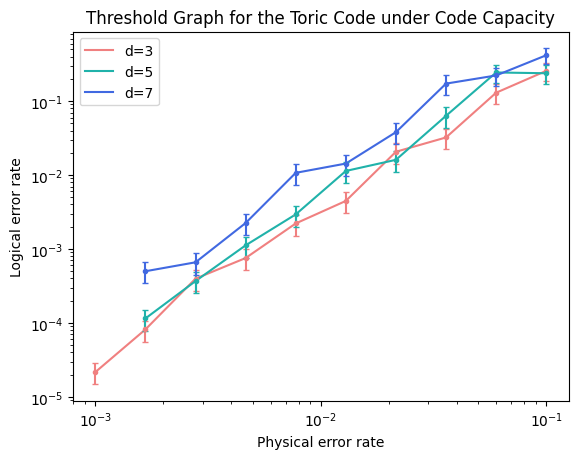

In [207]:
# Plotting

x = np.logspace(-3, -1, 10)
num_failures = {3 : 10, 5 : 10, 7 : 10}
plot_results, plot_error_bars = process_results(results_cap_qubit, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x[1:], plot_results[5][1:], color='lightseagreen')
plt.loglog(x[1:], plot_results[7][1:], color='royalblue')
# plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x[1:], plot_results[5][1:], yerr=plot_error_bars[5][1:], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x[1:], plot_results[7][1:], yerr=plot_error_bars[7][1:], fmt='.', capsize=2.5, color='royalblue')
# plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');